In [1]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "lsm" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "AEP" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
# param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False


In [3]:
# path='Datasets/LondonSmartMeter' # if under experiments folder
path = '.'
seq_len = param_dset_lookback
pred_horz = param_dset_forecast
weather = param_trf_weather
timestamps = False
weather = False


if 'lsm_dict.pkl.pgz' not in os.listdir(path):
    subprocess.check_call('python ./LondonSmartMeter_hhour.py ./LondonSmartMeter lsm_dict.pkl')
if 'londonWeather.pkl.pgz' not in os.listdir(path):   
    raise ValueError

with pgzip.open(os.path.join(path,'lsm_dict.pkl.pgz'),'rb') as f:
    s_dict = pickle.load(f)
    


In [4]:
# print(s_dict)
print(len(s_dict[2]))
print(len(s_dict))

print(s_dict[2][1].shape)

2
5561
torch.Size([24192])


In [5]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
    print("Maximum decomposition level:", max_level)
    
    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    '''
    Converts time series to wave
    '''
    da = []
    coeffs = []
    
    for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
        for j in range(len(dataset[0])-window):
            coeffs_j = pywt.swt(dataset[i][j:window+j], wavelet='db2', level=lev)
            coeffs.append(coeffs_j)
            
        da.append(coeffs);
        coeffs = []
    return da

def data_reconstruction(dataset, window):
    '''
    Converts wave back to time series
    Take window-1 (last) value since we predict this value based on window
    '''
    full_recon = []
    for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
        da = []
        for j in range(len(dataset[0])):
            recon = pywt.iswt(dataset[i][j], 'db2')
            da.append(recon[window-1])
        full_recon.append(da)

    return full_recon


# Called because iswt cannot accept tolist() dataset
def data_organization(data):
    '''
    Reshape data back to (n,m,3,2,window_length), 
    n number of different household, m number of timelines
    where there are 3 tuples of 2 values consisting of 
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    full_reshape_list = []
    for i in range(len(data)):
        reshape_list = []
        for j in range(len(data[0])):
            reshape_list.append([])
            for k in range(len(data[0][0])):
                reshape_list[j].append(tuple(data[i][j][k]))
        
        full_reshape_list.append(reshape_list)    
    
    return full_reshape_list

In [6]:
self_has_weather = weather
self_return_timestamps = timestamps

self_weather_dict = None
if self_has_weather:
    with pgzip.open(os.path.join(path,'londonWeather.pkl.pgz'),'rb') as f2:
        weather_dict = pickle.load(f2)

    self_weather_dict = weather_dict

#s_dict is dictionary as follows: { lclid: (start_timestamp,Tensor), ...}

#List to store the dataset indices corresponding to each household
self_household_idxs = [None]*len(s_dict)
#List to hold the split series
self_series = [None]*len(s_dict)
#These two lists will be converted to torch tensors
self_start_times = []
self_pred_starttimes = []
#These two lists stores the datetime format
self_start_times__ = []
#self.pred_starttimes__ = []

index_count = 0

# Enumerate all keys in dictionary -> lclid
for index, lclid in enumerate(s_dict.keys()):    
    start_time, s_tensor = s_dict[lclid]
    #start_time[0] = start_time[0]%400
    
    #pad_amt = (seq_len+pred_horz) - (len(s_tensor)%(seq_len+pred_horz))
    #s_tensor = torch.nn.functional.pad(s_tensor,pad = (pad_amt,0), value = torch.nan)
    
    #Split into chunks of seq_len+pred_horz length each
    s_tensors = s_tensor.split(seq_len+pred_horz)

    #Compute start timestamps for splits
    start_times = [None]*len(s_tensors)
    pred_starttimes = [None]*len(s_tensors)

    for i in range(len(start_times)):
        minutes_delta = 30*i*(seq_len + pred_horz)
        time_delta = datetime.timedelta(minutes=minutes_delta)
        new_start_time = start_time + time_delta
        start_times[i] = new_start_time

    # Reinitialised for computation of prediction start time
    minutes_delta = 30*seq_len
    time_delta = datetime.timedelta(minutes=minutes_delta)

    #Compute prediction start timestamps
    for i in range(len(pred_starttimes)):
        new_predtime = start_times[i] + time_delta
        pred_starttimes[i] = [new_predtime.year,
                              new_predtime.month,
                              new_predtime.day,
                              new_predtime.hour,
                              new_predtime.minute,
                              new_predtime.second]

    ''' 
    A shallow copy, li2, is created using copy.copy(), 
    preserving the top-level structure but sharing references to the inner lists. 
    A deep copy, li3, is created using copy.deepcopy(), resulting in a completely 
    independent copy of li1, including all nested elements
    '''
    
    start_times__ = copy.deepcopy(start_times)
    for i in range(len(start_times)):
        new_start_time = start_times[i]
        start_times[i] = [new_start_time.year,
                          new_start_time.month,
                          new_start_time.day,
                          new_start_time.hour,
                          new_start_time.minute,
                          new_start_time.second]

    #Remove last if length less than the others
    if s_tensors[-1].shape[0] < seq_len+pred_horz:
        s_tensors = s_tensors[:-1]
        start_times = start_times[:-1]
        pred_starttimes = pred_starttimes[:-1]
        start_times__ = start_times__[:-1]

    if len(s_tensors) == 0:
        self_series[index] = torch.empty(0)                    
    else:
        '''
        torch.stack()
        Concatenates a sequence of tensors along a new dimension.
        All tensors need to be of the same size.
        '''
        s_tensors = torch.stack(s_tensors)
        # Remove invalid (more than 4/5 (80%) of series is 0 or nan)
        s_tensors[s_tensors==0] = torch.nan # 0s are invalid too, replace with nan
        # Count those tensor index with less than 80% invalid
        sel = (( (s_tensors==0) | s_tensors.isnan()).sum(dim=-1) < (4*(seq_len+pred_horz)//5))
        s_tensors = s_tensors[sel]
        
        # Get start, prediction times for those with less than 80% nan
        start_times_ = [start_times[i] for i in range(len(start_times)) if sel[i]]
        pred_starttimes_ = [pred_starttimes[i] for i in range(len(pred_starttimes)) if sel[i]]
        _start_times__ = [ start_times__[i] for i in range(len(start_times__)) if sel[i]]
        
        self_series[index] = s_tensors
        if index==0:
            print("before series:", self_series[0].shape)
        self_start_times = self_start_times + start_times_
        if index==0:
            print("start_times_ after: ", start_times_)
            print("start_times after: ", start_times)
        self_pred_starttimes = self_pred_starttimes + pred_starttimes_
        self_start_times__ = self_start_times__ + _start_times__

    if len(s_tensors) == 0:
        self_household_idxs[index] = []
    else:
        self_household_idxs[index] = list(range(index_count,index_count+len(s_tensors)))
        index_count = index_count + len(s_tensors)
        
print("before concat series:", len(self_series))
print("before concat series:", self_series[0].shape)
# Concat all households series but retain 1680 seq_len predictions
self_series = torch.cat(self_series,dim=0).unsqueeze(-1)
print("before normalization series:", self_series.shape)

self_start_times = torch.tensor(self_start_times,dtype = torch.long)
self_pred_starttimes = torch.tensor(self_pred_starttimes,dtype = torch.long)

#self.series[:,:seq_len] = self.series[:,:seq_len].nan_to_num(nan=0.,posinf=0.,neginf=0.)

#Series normalization
smin = self_series.nan_to_num(nan=torch.finfo(self_series.dtype).max).amin(dim=-2,keepdim=True)
smax = self_series.nan_to_num(nan=torch.finfo(self_series.dtype).min).amax(dim=-2,keepdim=True)
# Normalize over dimension -2, which is seq_len + prediction len
self_series = (self_series - smin.broadcast_to(self_series.shape))/(smax-smin+1e-10).broadcast_to(self_series.shape)

print("total series shape: ", self_series.shape)


if self_has_weather:
    #Weather series normalization
    #Only dimensions 0, 3, 4, 5, 6, 7 needs normalization
    wdmin = self_weather_dict['tensor'].nan_to_num(nan=torch.finfo(self_weather_dict['tensor'].dtype).max).amin(dim=-2,keepdim=True)
    wdmax = self_weather_dict['tensor'].nan_to_num(nan=torch.finfo(self_weather_dict['tensor'].dtype).min).amax(dim=-2,keepdim=True)
    self_weather_dict['tensor'] = (self_weather_dict['tensor'] - wdmin.broadcast_to(self_weather_dict['tensor'].shape))\
        /(wdmax-wdmin + 1e-10).broadcast_to(self_weather_dict['tensor'].shape)

    self_weather_dict['tensor'] = self_weather_dict['tensor'].type(torch.float32)

self_length = len(self_series)
self_seq_len = seq_len
self_pred_horz = pred_horz

before series: torch.Size([8, 3024])
start_times_ after:  [[2012, 10, 12, 0, 30, 0], [2012, 12, 14, 0, 30, 0], [2013, 2, 15, 0, 30, 0], [2013, 4, 19, 0, 30, 0], [2013, 6, 21, 0, 30, 0], [2013, 8, 23, 0, 30, 0], [2013, 10, 25, 0, 30, 0], [2013, 12, 27, 0, 30, 0]]
start_times after:  [[2012, 10, 12, 0, 30, 0], [2012, 12, 14, 0, 30, 0], [2013, 2, 15, 0, 30, 0], [2013, 4, 19, 0, 30, 0], [2013, 6, 21, 0, 30, 0], [2013, 8, 23, 0, 30, 0], [2013, 10, 25, 0, 30, 0], [2013, 12, 27, 0, 30, 0]]
before concat series: 5561
before concat series: torch.Size([8, 3024])
before normalization series: torch.Size([52713, 3024, 1])
total series shape:  torch.Size([52713, 3024, 1])


In [7]:
dat = self_series[:200]

print(dat.shape)
# alpha=0.6667

alpha = 0.6
beta = 0.8


train_set = dat[:int(dat.shape[0]*alpha),:,:]
val_set = dat[int(dat.shape[0]*alpha):int(dat.shape[0]*beta),:,:]
test_set = dat[int(dat.shape[0]*beta):,:,:]

print(train_set.shape)
print(val_set.shape)
print(test_set.shape)


torch.Size([200, 3024, 1])
torch.Size([120, 3024, 1])
torch.Size([40, 3024, 1])
torch.Size([40, 3024, 1])


In [8]:
#SWT Transformation
def swt_transformation(self_series, window, lev):
    self_series = self_series.squeeze(-1)
    print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
    print("torch shape: ", self_series.shape)
    print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])

    da = data_preparation(self_series_numpy, window, lev)
#     print(da[0][0])

    Vv = np.array(da)
    print(Vv.shape)
#     print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],Vv.shape[1],2*lev*Vv.shape[4])
    print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],Vv.shape[1],2*lev,Vv.shape[4])
    print(dat.shape)
    
    return dat
    
window = param_dset_lookback
max_level = print_maximal_decom_level(window)
lev = max_level if max_level < 3 else 3

train_set_transform = swt_transformation(train_set, window, lev)
print("train_set_transform shape: ", train_set_transform.shape)
print("----------------------------------------------------")

val_set_transform = swt_transformation(val_set, window, lev)
print("val_set_transform shape: ", val_set_transform.shape)
print("----------------------------------------------------")

test_set_transform = swt_transformation(test_set, window, lev)
print("test_set_transform shape: ", test_set_transform.shape)
print("----------------------------------------------------")

Maximum decomposition level: 5
total series shape after squeeze:  torch.Size([120, 3024])
torch shape:  torch.Size([120, 3024])
numpy shape:  (120, 3024)


swt:   0%|          | 0/120 [00:00<?, ?it/s]

(120, 48, 3, 2, 2976)
(120, 48, 17856)
(120, 48, 6, 2976)
train_set_transform shape:  (120, 48, 6, 2976)
----------------------------------------------------
total series shape after squeeze:  torch.Size([40, 3024])
torch shape:  torch.Size([40, 3024])
numpy shape:  (40, 3024)


swt:   0%|          | 0/40 [00:00<?, ?it/s]

(40, 48, 3, 2, 2976)
(40, 48, 17856)
(40, 48, 6, 2976)
val_set_transform shape:  (40, 48, 6, 2976)
----------------------------------------------------
total series shape after squeeze:  torch.Size([40, 3024])
torch shape:  torch.Size([40, 3024])
numpy shape:  (40, 3024)


swt:   0%|          | 0/40 [00:00<?, ?it/s]

(40, 48, 3, 2, 2976)
(40, 48, 17856)
(40, 48, 6, 2976)
test_set_transform shape:  (40, 48, 6, 2976)
----------------------------------------------------


In [9]:
# Split seq_len and pred
seq_len = 1
print(window)

trainX, trainY = train_set_transform[:,:,:,window-seq_len-1:window-1], train_set_transform[:,:,:,window-1]
valX, valY = val_set_transform[:,:,:,window-seq_len-1:window-1], val_set_transform[:,:,:,window-1]
testX, testY = test_set_transform[:,:,:,window-seq_len-1:window-1], test_set_transform[:,:,:,window-1]

print(trainX.shape)
print(valX.shape)
print(testX.shape)
print(trainY.shape)

trainX = np.transpose(trainX, (0, 1, 3, 2))
valX = np.transpose(valX, (0, 1, 3, 2))
testX = np.transpose(testX, (0, 1, 3, 2))

print(trainX.shape)
print(valX.shape)
print(testX.shape)



2976
(120, 48, 6, 1)
(40, 48, 6, 1)
(40, 48, 6, 1)
(120, 48, 6)
(120, 48, 1, 6)
(40, 48, 1, 6)
(40, 48, 1, 6)


## Model Initialization

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.rand(seq_len, requires_grad=True))
        self.bias_linear = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.weights_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.bias_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        
        # Initialize parameters with uniform distribution
        nn.init.uniform_(self.weights_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.weights_periodic, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_periodic, a=0.0, b=1.0)

    def forward(self, x):
        x = torch.mean(x[:, :, :], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

    def extra_repr(self):
        return f'seq_len={self.seq_len}'

In [12]:
class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v, inp_len):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.query = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.zeros_(self.query.bias)

        self.key = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.zeros_(self.key.bias)

        self.value = nn.Linear(in_features=inp_len, out_features=d_v)
        nn.init.xavier_uniform_(self.value.weight)
        nn.init.zeros_(self.value.bias)

    def forward(self, inputs):

        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = torch.matmul(q, k.transpose(-2, -1))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn_weights = F.softmax(attn_weights, dim=-1)

        v = self.value(inputs[2])
        attn_out = torch.matmul(attn_weights, v)
        return attn_out
    
class MultiAttention(nn.Module):
    def __init__(self, d_k, d_v, n_heads, inp_len):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        
        self.attn_heads = nn.ModuleList([SingleAttention(d_k, d_v, inp_len) for _ in range(n_heads)])
        
        self.linear = nn.Linear(d_k * n_heads, inp_len)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = torch.cat(attn, dim=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [13]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=self.ff_dim, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=self.ff_dim, kernel_size=1)
#         self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=8, kernel_size=1)
        self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
#         print(len(inputs))
#         print(inputs[0].shape)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        # Correction for transpose
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2))
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
#         ff_layer = self.ff_conv1D_2(ff_layer).transpose(1, 2)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer
    
class TransformerDecoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)
        
        # Transpose for pytorch implementation
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2)).transpose(1, 2)
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

In [14]:
class SWT_Transformer(nn.Module):
    def __init__(self, seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim):
        super(SWT_Transformer, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.time_embedding = Time2Vector(seq_len)
        
        self.layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(seq_len, 128)
        self.fc2 = nn.Linear(128, out_len)

    def forward(self, x):
        in_seq = x
        
        time_embedding = self.time_embedding(in_seq)
        x = torch.cat([in_seq, time_embedding], dim=-1)
        
        x = self.layer1((x, x, x))
        x = self.layer2((x, x, x))
        x = self.layer3((x, x, x))
        x = self.layer4((x, x, x))
        x = self.layer5((x, x, x))

        x = self.pooling(x).squeeze(2)
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        out = self.fc2(x)

        return out

## Create model and data tensor

In [15]:
batch_size = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
inp_len = 2*lev + 2 # 2 from time2Vector embedding
out_len = 2*lev

# lev = 3
# seq_len = 1
# window = 200
# look_back = 12

In [16]:
# model = create_model()
# model.summary()

# # Training data
# X_train, y_train = trainX,trainY
# ###############################################################################
# # Validation data
# X_val, y_val = testX,testY
# ###############################################################################
# # Test data
# X_test, y_test = testX_a,testY_a
# callback = tf.keras.callbacks.ModelCheckpoint('Transformer_5min.hdf5',
#                                                       monitor='val_loss',
#                                                       save_best_only=True,
#                                                       verbose=1)
# with tf.device("/gpu:0"):
#     history = model.fit(X_train, y_train,
#                             batch_size=batch_size,
# #                             epochs=50,
#                             epochs=1,
#                             validation_data=(X_val, y_val),
#                             callbacks=[callback])

# model = tf.keras.models.load_model('Transformer_5min.hdf5',
#                                            custom_objects={'Time2Vector': Time2Vector,
#                                                            'SingleAttention': SingleAttention,
#                                                            'MultiAttention': MultiAttention,
#                                                            'TransformerEncoder': TransformerEncoder,
#                                                            'TransformerDecoder': TransformerDecoder}
#                                            )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")


# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

Grad_scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 20  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Convert data to PyTorch tensors
X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
X_val, y_val = torch.tensor(valX), torch.tensor(valY)
X_test, y_test = torch.tensor(testX), torch.tensor(testY)
    
for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    mean_train_loss = 0.0
    
    for i in tqdm(range(len(X_train)), total=len(X_train), desc="train"):
        # Create DataLoader for training data
        train_dataset = TensorDataset(X_train[i], y_train[i])
        train_loader = DataLoader(train_dataset, batch_size=batch_size)

        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
#             print(inputs.shape)
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            optimizer.zero_grad()
#             outputs = model(inputs)       
            
            with torch.cuda.amp.autocast(dtype=torch.float16):
                outputs = model(inputs)
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
        
                optimizer.zero_grad()
                Grad_scaler.scale(loss).backward()
                Grad_scaler.step(optimizer)
                Grad_scaler.update()

#             loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
# #             print(loss)
# #                 print("targets: ", targets.shape)
# #                 print("outputs: ", outputs.shape)
# #                 loss = criterion(outputs, targets)
#             loss.backward()
#             optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        mean_train_loss += train_loss
        
    mean_train_loss /= len(X_train)
    
    model.eval()
    
    mean_val_loss = 0.0
    
    for j in tqdm(range(len(X_val)), total=len(X_val), desc="Validation"):
        # Create DataLoader for Validation data
        val_dataset = TensorDataset(X_val[j], y_val[j])
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
            
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
                outputs = model(inputs)
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
#                 val_loss += criterion(outputs, targets).item()
                val_loss += loss

        val_loss /= len(val_loader)
        mean_val_loss += val_loss
        
    mean_val_loss /= len(X_val)
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {mean_train_loss:.6f}, Validation Loss: {mean_val_loss:.6f}')
    
    # Save the PyTorch model
    torch.save(model.state_dict(), 'transformer_5min.pth')


Actual number of model parameters: 541145
Trainable model parameters: 541145


epochs:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/20, Training Loss: 0.038394, Validation Loss: 0.022991


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/20, Training Loss: 0.024001, Validation Loss: 0.023375


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/20, Training Loss: 0.022131, Validation Loss: 0.020061


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/20, Training Loss: 0.020798, Validation Loss: 0.016425


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/20, Training Loss: 0.020056, Validation Loss: 0.018064


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/20, Training Loss: 0.019542, Validation Loss: 0.019380


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/20, Training Loss: 0.018825, Validation Loss: 0.019552


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/20, Training Loss: 0.018986, Validation Loss: 0.016083


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/20, Training Loss: 0.017804, Validation Loss: 0.017092


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/20, Training Loss: 0.018275, Validation Loss: 0.017095


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/20, Training Loss: 0.018338, Validation Loss: 0.015262


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/20, Training Loss: 0.017432, Validation Loss: 0.014771


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/20, Training Loss: 0.018396, Validation Loss: 0.014675


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/20, Training Loss: 0.016680, Validation Loss: 0.015440


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/20, Training Loss: 0.017075, Validation Loss: 0.014559


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/20, Training Loss: 0.017185, Validation Loss: 0.016129


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/20, Training Loss: 0.016070, Validation Loss: 0.014185


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/20, Training Loss: 0.016569, Validation Loss: 0.013851


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/20, Training Loss: 0.016841, Validation Loss: 0.014174


train:   0%|          | 0/120 [00:00<?, ?it/s]

Validation:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/20, Training Loss: 0.016814, Validation Loss: 0.014257


In [17]:
# Load the PyTorch model
loaded_model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)
loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

# Use the whole signal (both train and validation data)
# The metrics are computed only using the validation part.
# This is needed for the signal processing
print(testX.shape)

# Testing the model on the test dataset
full_test_outputs = []
mean_test_loss = 0.0

for j in tqdm(range(len(X_test)), total=len(X_test), desc="Test"):
    # Create DataLoader for Test data
    test_dataset = TensorDataset(X_test[j], y_test[j])
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    test_loss = 0.0
    test_outputs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = loaded_model(inputs)
            test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

            loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
            test_loss += loss
    #         test_loss += criterion(outputs, targets).item()

    testPredict = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
    full_test_outputs.append(testPredict)
    test_loss /= len(test_loader)
    mean_test_loss += test_loss
    
mean_test_loss /= len(X_test)

print(f'Test Loss: {mean_test_loss:.6f}')

# Result from test
print(np.array(full_test_outputs).shape)

d = test_set_transform
print(d.shape)

# Prediction place at the end of the wave
# In iswt, we will take the last value as our prediction
d[:,:,:,window-1] = full_test_outputs
print(d.shape)

D = d.reshape(d.shape[0],d.shape[1],d.shape[2]*d.shape[3])
print(D.shape)

(40, 48, 1, 6)


Test:   0%|          | 0/40 [00:00<?, ?it/s]

Test Loss: 0.011068
(40, 48, 6)
(40, 48, 6, 2976)
(40, 48, 6, 2976)
(40, 48, 17856)


In [18]:
R = D.reshape(d.shape[0],d.shape[1],lev,2,d.shape[3])
print(R.shape)

R = data_organization(R)

# Change to tuple type for iswt
print(len(R[0][0][0]))
print(type(R[0][0][0]))

re=data_reconstruction(R, window)

# Prediction for next 48 data in test set
Re = np.array(re)
print(Re.shape)

Re = torch.from_numpy(Re)

(40, 48, 3, 2, 2976)
2
<class 'tuple'>


iswt:   0%|          | 0/40 [00:00<?, ?it/s]

(40, 48)


In [19]:
# Original Data
test_actual = test_set[:, param_dset_lookback:]
print(test_actual.shape)

test_actual = test_actual.squeeze(-1)
print(test_actual.shape)


# This was included in the original transformer_houses1to5_5min program
Re, test_actual=Re[:,1:], test_actual[:,:-1] # I don't understand
# Similarly, taking the values 1 time step before results in the equally good RMSE value
# test_actual = test_set[:, param_dset_lookback-1:param_dset_lookback-1+param_dset_forecast]

torch.Size([40, 48, 1])
torch.Size([40, 48])


In [20]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

# Input contains Nan
# test_rmse = math.sqrt( mean_squared_error(test_actual, Re))
# test_mae=mean_absolute_error(test_actual, Re)
# mape=100*np.mean(np.divide(abs(test_actual- Re),test_actual))

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, Re).nanmean().sqrt_()

test_mae = (Re-test_actual).abs_().nanmean()

mape = (2*(test_actual-Re).abs_() / (test_actual.abs() + Re.abs())).nanmean()



In [21]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.013618
MAE:  0.008930
MAPE:  0.153955


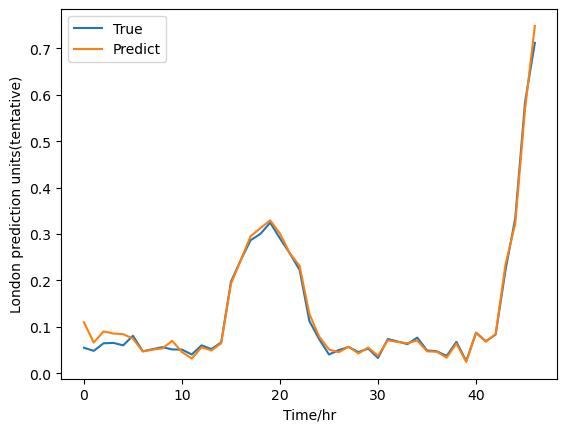

In [22]:
fig = plt.figure()
plt.plot(test_actual[0])
plt.plot(Re[0])
plt.xlabel('Time/hr')
plt.ylabel('London prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


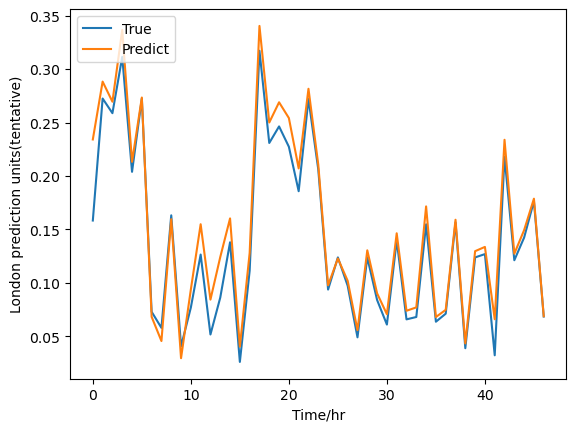

In [23]:
fig = plt.figure()
plt.plot(test_actual[1])
plt.plot(Re[1])
plt.xlabel('Time/hr')
plt.ylabel('London prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

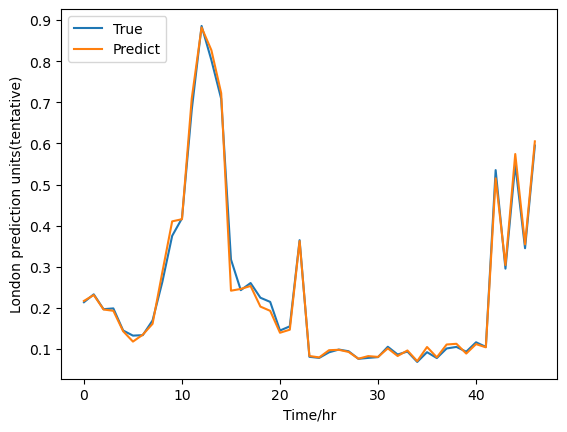

In [24]:
fig = plt.figure()
plt.plot(test_actual[20])
plt.plot(Re[20])
plt.xlabel('Time/hr')
plt.ylabel('London prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

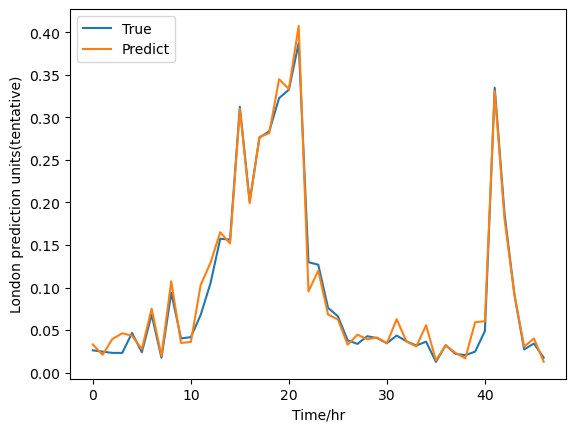

In [25]:
fig = plt.figure()
plt.plot(test_actual[30])
plt.plot(Re[30])
plt.xlabel('Time/hr')
plt.ylabel('London prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

In [26]:
print(Re[20])

tensor([0.2171, 0.2314, 0.1962, 0.1931, 0.1434, 0.1183, 0.1350, 0.1615, 0.2874,
        0.4106, 0.4157, 0.7098, 0.8819, 0.8268, 0.7223, 0.2420, 0.2462, 0.2534,
        0.2033, 0.1930, 0.1397, 0.1471, 0.3625, 0.0832, 0.0798, 0.0973, 0.0983,
        0.0931, 0.0766, 0.0830, 0.0810, 0.1018, 0.0832, 0.0967, 0.0707, 0.1051,
        0.0800, 0.1112, 0.1129, 0.0891, 0.1121, 0.1043, 0.5152, 0.3044, 0.5743,
        0.3546, 0.6051])


In [27]:
data = self_series[0].squeeze(-1)
data = data.numpy()
print(data)

swt = pywt.swt(data, wavelet='db2', level=lev)
recon = pywt.iswt(swt, 'db2')
recon

[       nan        nan        nan ... 0.08361203 0.07931198 0.07453416]


array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)